In [329]:
import numpy as np
import matplotlib.pyplot as plt


# class Person:
# #     age_group = 1 2 3 4 
# #     infected = 0 1
# #     antybodies = 0 1 
    
#     def __init__(self, age_group, infected, antybodies):
#         self.age_group = age_group
#         self.infected = infected
#         self.antybodies = antybodies
    
    
class Configuration:
    """Configuration (lattice) of the problem"""
    
    def __init__(self, population, N, M, beta, T_inf, Ts, Sage): 
        """Constructor"""
        self.M = M # the length of the lattice (we assume it is square)
        self.population = population # it's a vector (1*4) which contains population percatages for each group
        self.N = N # total population
        self.beta = beta # age dependent inverse mobility 
        self.T_inf = T_inf # infective period
        self.Ts = Ts # after Ts after infection person goes through symptomatic phase
        self.Sage = Sage # specific age-class susceptibility
        self.infected = np.zeros(4) # the number of infected people at each group
        
        # config - 3D matrix. 
        # 1st layer M[0,:,:] corresponds to population distribution: 0 - the site is free, 1-4 the site is occupied by a parson from corresponding age group
        # 2nd layer M[1,:,:] corresponds to the "Infected" property of an individual. If the site is occupied then it is 1 or 0, otherwise np.nan
        # 3d layer M[2,:,:], likewise, corresponds to the "Antibodies" property of an individual.
        self.config = np.zeros((M, M, 4)) 
        
        self.population[0] = round(self.population[0] * N/100)
        self.population[1] = round(self.population[1] * N/100)
        self.population[2] = round(self.population[2] * N/100)
        self.population[3] = N - (self.population[0] + self.population[1] + self.population[2]) # to make sum equal to N
        
        # create the 1st layer of the conf M*M matrix. Population is randomly distributed
        A = np.hstack([1*np.ones(self.population[0]), 2*np.ones(self.population[1]), 3*np.ones(self.population[2]), 4*np.ones(self.population[3]), np.zeros(self.M**2 - N)]) 
        # create the 2nd and 3d layer of the conf M*M matrix. Population is randomly distributed
        # 95% are healthy, 5% are ill
        B = np.hstack([np.random.choice([0, 1], size = (self.N), p = [0.95, 0.05]), np.nan * np.ones(self.M**2 - N)]) 
        C = np.hstack([np.random.choice([0, 1], size = (self.N), p = [0.99, 0.01]), np.nan * np.ones(self.M**2 - N)]) 
        # Create the 4th layer which contains time, if a person is infected, time starts from T_inf, then each step T_inf -1
        # at time t = 0 the person recovers
        D = np.hstack([np.random.choice(np.arange(1, T_inf+1), size = (self.N)), np.nan*np.ones(self.M**2-N)])
        D[B == 0] = np.nan
        # those who are infective do not have antibodies -> if B[i, j, 2] = 1 -> B[i, j, 3] = 0
        C[B == 1] = 0
        
        # then we reshape and shuffle it to make random
        E = np.vstack([A, B, C, D])
        # we transpose because the shuffle function shuffles only along the 1st axis  
        E = np.transpose(E)
        np.random.shuffle(E)
        E = np.transpose(E)
        A, B, C, D = E[0], E[1], E[2], E[3]
        self.config = np.stack([A.reshape((M,M)), B.reshape((M,M)), C.reshape((M,M)), D.reshape((M,M))])
        self._calculate_infected()
        
    def _calculate_infected(self):
        """Calculate the number of infected people at each group"""
        for i in range(4):
            self.infected[i] = np.sum(self.config[1][self.config[0] == i + 1])
        return self.infected
        
    def _near_neighbors(self, i, j):
        return int(self.config[0][i][j] == self.config[0][i][(j + 1)%self.M]) + (self.config[0][i][j] == self.config[0][i][j - 1]) + (self.config[0][i][j] == self.config[0][(i + 1)%self.M][j]) + (self.config[0][i][j] == self.config[0][i - 1][j])
    
                       
    def _imagesc(self):
        """Show population on a 2D plot"""
        
        a = np.zeros((self.M, self.M))
        a[self.config[1,:,:] == 1] = 2
        a[self.config[1,:,:] == 0] = 1
        plt.imshow(a, vmin = 0, vmax = 2, cmap = 'jet', aspect = 'auto')
        plt.colorbar()
        plt.show()
        
    def _return_imagesc(self):
        """Return matrix population on a 2D plot"""
        
        a = np.zeros((self.M, self.M))
        a[self.config[1,:,:] == 1] = 2
        a[self.config[1,:,:] == 0] = 1
        return a
        

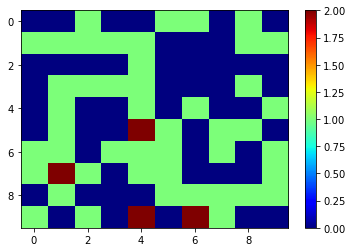

[[[ 0.  0.  4.  0.  0.  4.  4.  0.  4.  0.]
  [ 3.  1.  2.  3.  3.  0.  0.  0.  2.  4.]
  [ 0.  0.  0.  0.  4.  0.  0.  0.  0.  0.]
  [ 0.  1.  2.  2.  4.  0.  0.  0.  1.  0.]
  [ 0.  4.  0.  0.  3.  0.  3.  0.  0.  2.]
  [ 0.  3.  0.  0.  4.  2.  0.  4.  2.  0.]
  [ 2.  4.  0.  3.  3.  4.  0.  1.  0.  3.]
  [ 4.  4.  4.  0.  4.  3.  0.  0.  0.  3.]
  [ 0.  4.  0.  0.  0.  2.  4.  3.  4.  2.]
  [ 3.  0.  3.  0.  1.  0.  3.  4.  0.  0.]]

 [[nan nan  0. nan nan  0.  0. nan  0. nan]
  [ 0.  0.  0.  0.  0. nan nan nan  0.  0.]
  [nan nan nan nan  0. nan nan nan nan nan]
  [nan  0.  0.  0.  0. nan nan nan  0. nan]
  [nan  0. nan nan  0. nan  0. nan nan  0.]
  [nan  0. nan nan  1.  0. nan  0.  0. nan]
  [ 0.  0. nan  0.  0.  0. nan  0. nan  0.]
  [ 0.  1.  0. nan  0.  0. nan nan nan  0.]
  [nan  0. nan nan nan  0.  0.  0.  0.  0.]
  [ 0. nan  0. nan  1. nan  1.  0. nan nan]]

 [[nan nan  0. nan nan  0.  0. nan  0. nan]
  [ 0.  0.  0.  0.  0. nan nan nan  0.  0.]
  [nan nan nan nan  0. nan n

In [330]:
# __init__(self, population, N, M, beta, T_inf, Ts, Sage): 
c = Configuration([10, 20, 30, 40], 50, 10, 1, 10, 5, [0.1, 0.2, 0.3, 0.5])
c._imagesc()
print(c.config)
plt.show()

<br>

In [331]:
def metropolis_move(obj):
    """Modify (or not) a configuration with Metropolis algorithm"""

    
    M = obj.M
    beta = obj.beta
#     obj._calculate_infected()
    
    # At the beginning of each timestep, we consider the infected people recover. 
    # We go through the lattice and recover certain people whose infection time has come.
    obj.config[3][obj.config[3] > 0] -= 1 # if time is more than zero then subtract 1
    obj.config[1][obj.config[3] == 0] = 0 # if time for individual is zero, then he recovers
    obj.config[2][obj.config[3] == 0] = 1
    
    
    #Do we consider the exit condistions as a step?
    
    
    # randomly choose an individual located at site 1
    i, j = np.random.randint(M, size = (2)) 

    # we exit the function if there is NO person at the randomly selected site
    age_group = obj.config[0][i][j]
    if age_group == 0:
        return None 
    
    # We implement the first adaptive rule: the infected person stops moving if he goes through symptomatic phase (T < Ts)
    if obj.config[1][i][j] == 1 and obj.config[3][i][j] < obj.T_inf - obj.Ts:
        return None
    
    
    # randomly choose nearest neighbor destination (site 2)
    i1 = np.random.choice([-1, 0, 1])
    if i1 == 0:
        j1 = np.random.choice([-1, 1])
    else:
        j1 = 0
    
    # we exit the function if there IS person at the randomly selected destination site 2
    if obj.config[0][(i + i1)%M][(j + j1)%M] != 0:
        return None 
    
    # We implement the second adaptive rule: susceptible individuals tend to avoid contacts with the infected ones 
    # in their symptomatic phase #BETTER RECHECK
    if obj.config[1][i][j] == 0 and \
    ((obj.config[1][(i+i1-1)%M][(j+j1)%M] == 1 and obj.config[3][(i+i1-1)%M][(j+j1)%M] < obj.T_inf - obj.Ts) or \
     (obj.config[1][(i+i1+1)%M][(j+j1)%M] == 1 and obj.config[3][(i+i1+1)%M][(j+j1)%M] < obj.T_inf - obj.Ts) or \
     (obj.config[1][(i+i1)%M][(j+j1+1)%M] == 1 and obj.config[3][(i+i1+1)%M][(j+j1)%M] < obj.T_inf - obj.Ts) or \
     (obj.config[1][(i+i1)%M][(j+j1-1)%M] == 1 and obj.config[3][(i+i1-1)%M][(j+j1)%M] < obj.T_inf - obj.Ts)) :
        return None 
    
    
    # compute the difference of nearest neighbor effective number for sites 1 and 2
    delta_N = obj._near_neighbors((i + i1)%M, (j + j1)%M) - obj._near_neighbors(i, j)
    
    
    # accept modification with Metropolis probability
    # if not accepted: leave configuration unchanged
    if np.random.random() < min(1, np.exp(-beta*delta_N)):
        obj.config[:, (i + i1)%M, (j + j1)%M] = obj.config[:, i, j]
        obj.config[:, i, j] = [0, np.nan, np.nan, np.nan]
        
        # if the selected person does not have antibodies and not infected and some of the new neighbors are infected 
        # then the person gets infected with probability Sage[age group]
        # 
        # Mb better to create new matrix (?)
        if np.random.random() < obj.Sage[int(age_group - 1)] and obj.config[1, (i + i1)%M, (j + j1)%M] == 0 and \
        obj.config[2, (i + i1)%M, (j + j1)%M] == 0 and \
        (obj.config[1, (i + i1 + 1)%M, (j + j1)%M] == 1 or obj.config[1, (i + i1 - 1)%M, (j + j1)%M] == 1 or \
        obj.config[1, (i + i1)%M, (j + j1 + 1)%M] == 1 or obj.config[1, (i + i1)%M, (j + j1 - 1)%M] == 1):
            obj.config[1, (i + i1)%M, (j + j1)%M] = 1
            obj.config[3, (i + i1)%M, (j + j1)%M] = obj.T_inf
            
        # if the selected person is infected, then new neighbors get infected as well
#         if obj.config[1, (i + i1)%M, (j + j1)%M] == 1:
#             if obj.config[1, (i + i1 + 1)%M, (j + j1 + 1)%M] == 0: obj.config[1, (i + i1 + 1)%M, (j + j1 + 1)%M] = 1 
#             if obj.config[1, (i + i1 - 1)%M, (j + j1 + 1)%M] == 0: obj.config[1, (i + i1 - 1)%M, (j + j1 + 1)%M] = 1 
#             if obj.config[1, (i + i1 + 1)%M, (j + j1 - 1)%M] == 0: obj.config[1, (i + i1 + 1)%M, (j + j1 - 1)%M] = 1 
#             if obj.config[1, (i + i1 - 1)%M, (j + j1 - 1)%M] == 0: obj.config[1, (i + i1 - 1)%M, (j + j1 - 1)%M] = 1 
            
        

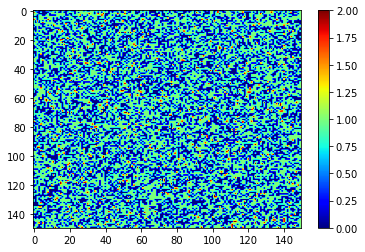

In [335]:
%matplotlib inline
# __init__(self, population, N, M, beta, T_inf, Ts, Sage): 
# c = Configuration([4.8, 9.3, 65.9, 20], 13000, 150, 0, 10000000, 10000000, [0.07, 0.12, 0.019, 0.004])
c = Configuration([4.8, 9.3, 65.9, 20], 13000, 150, 0, 100000, 100000, [1, 1, 1, 1])
# print(c.config)
c._imagesc()


# make move
# for i in range(20):
#     metropolis_move(c)
# c._imagesc()

In [336]:
infected = np.array([0,0,0,0])

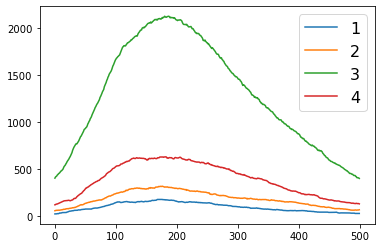

In [337]:
# infected = []

# print(c.infected)
for i in range(500):
    for j in range(1000):
        metropolis_move(c)
    infected = np.vstack([infected, c._calculate_infected()])
# print(infected)

infected = infected[1:,:]
plt.plot(infected[:, 0], label="1")
plt.plot(infected[:, 1], label="2")
plt.plot(infected[:, 2], label="3")
plt.plot(infected[:, 3], label="4")
plt.legend(fontsize = 16)

plt.show()

In [224]:
%matplotlib notebook
import matplotlib.animation as animation

length_cycle = 10

# firstly we create a figure (fig will be used by the animation function)
fig = plt.figure()

# we always start by creating a first plot
# important: plot returns a *list* of lines
im = plt.imshow(c._return_imagesc(), interpolation = 'none')

# a function that returns a *list* of the objects that are changed in the plot
def make_frame(i):
    
    for k in range(length_cycle):
        metropolis_move(c)
        
#     infected.append(c.infected)
    
    im.set_array(c._return_imagesc())
    return im

# animate
anim = animation.FuncAnimation(fig, make_frame, interval = 10, blit = False)
plt.show()

<IPython.core.display.Javascript object>